In [1]:
# Imports
import numpy as np
import random
import os

from keras.layers import Dense, Activation, LSTM, TimeDistributed, Dropout
from keras.optimizers import RMSprop
from keras.models import Sequential

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Parameters

max_length = 120

epochs = 60
batch_size = 256

In [3]:
# Load Data

def load_data(max_length=max_length, step=1, max_bills=12):

    chars = set()

    sequences, next_chars = [], []

    for bill_fn in os.listdir('data'):

        with open(os.path.join('data', bill_fn), 'r') as bill_file:
            bill = bill_file.read()

        chars |= set(bill)

        for i in range(0, len(bill) - max_length, step):
            sequences.append(bill[i: i + max_length])
            next_chars.append(bill[i + max_length])

        sequences.append(bill[-max_length:])
        next_chars.append('*END*')
        
        if max_bills == 0:
            break
        max_bills -= 1

    chars = sorted(list(chars)) + ['*END*']
    chr_to_int = dict((c, i) for i, c in enumerate(chars))
    int_to_chr = dict((i, c) for i, c in enumerate(chars))
    
    return (sequences, next_chars), (len(chars), chr_to_int, int_to_chr)


In [4]:
# Process Data

def process_data(sequences, next_chars, num_chars, chr_to_int):

    X = np.zeros((len(sequences), max_length, num_chars), dtype=np.bool)
    y = np.zeros((len(sequences), num_chars), dtype=np.bool)
    
    for i, sentence in enumerate(sequences):
        
        for t, char in enumerate(sentence):
            
            X[i, t, chr_to_int[char]] = 1
            
        y[i, chr_to_int[next_chars[i]]] = 1
        
    return X, y


In [5]:
# Get Model

def get_model(num_chars, max_length=max_length):

    model = Sequential()

    model.add(LSTM(512, input_shape=(max_length, num_chars), return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(512, return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(num_chars))

    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001))
    
    return model
    

In [6]:

def sample(preds, temperature=1.0):
    
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [7]:
# (Run) Load Data

if __name__ == "__main__":
    
    (sequences, next_chars), (num_chars, chr_to_int, int_to_chr) = load_data()
    
    X, y = process_data(sequences, next_chars, num_chars, chr_to_int)
    
    print(X.shape, y.shape)


(130243, 120, 80) (130243, 80)


Train on 117218 samples, validate on 13025 samples
Epoch 1/60
117218/117218 [==============================] - 373s - loss: 2.7472 - val_loss: 2.0279
Epoch 2/60
117218/117218 [==============================] - 365s - loss: 1.7717 - val_loss: 1.5132
Epoch 3/60
117218/117218 [==============================] - 365s - loss: 1.3292 - val_loss: 1.2510
Epoch 4/60
117218/117218 [==============================] - 369s - loss: 1.0719 - val_loss: 1.1266
Epoch 5/60
117218/117218 [==============================] - 370s - loss: 0.9051 - val_loss: 1.0695
Epoch 6/60
117218/117218 [==============================] - 371s - loss: 0.7875 - val_loss: 1.0535
Epoch 7/60
117218/117218 [==============================] - 371s - loss: 0.6955 - val_loss: 1.0404
Epoch 8/60
117218/117218 [==============================] - 371s - loss: 0.6185 - val_loss: 1.0488
Epoch 9/60
117218/117218 [==============================] - 372s - loss: 0.5562 - val_loss: 1.0442
Epoch 10/60
117218/117218 [==============================]

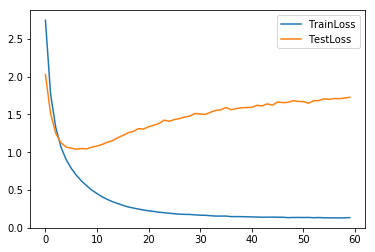

In [8]:
# (Run) Train

if __name__ == "__main__":
    
    model = get_model(num_chars)
    
    history = model.fit(X, y,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=.1,
                        verbose=1,
                        callbacks=[])
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['TrainLoss', 'TestLoss'])
    plt.show()


In [11]:

def generate_bill():

    bill_fn = random.choice(os.listdir('data'))

    with open(os.path.join('data', bill_fn), 'r') as bill_file:
        rand_bill = bill_file.read()

    new_bill = rand_bill[:max_length]
    print("Starting w/:\n" + new_bill)

    for i in range(15000):

        X = np.zeros((1, max_length, num_chars))

        for t, char in enumerate(new_bill[-max_length:]):
            X[0, t, chr_to_int[char]] = 1.

        preds = model.predict(X, verbose=0)[0]
        next_index = sample(preds, .9)

        if int_to_chr[next_index] != '*END*' or "body" == new_bill[-4:]:
            new_bill += int_to_chr[next_index]
        else:
            break

    with open('test.html', 'w') as bill_file:
        bill_file.write(new_bill)



In [12]:

if __name__ == "__main__":
    
    generate_bill()


Starting w/:
<body><p>S 1080 IS</p><p/><center><p>112th CONGRESS</p></center>
<p/><center><p>1st Session</p></center>
<p/><center><p>
